In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import os

In [31]:
def read_data(path, filename, delete_nans=False, verbose = False):
    df = pd.read_csv(f'{path}/{filename}')
    print(f"columns: {df.columns}")
    if verbose: print(f"all data length = {len(df)}")
    for col in df.columns:
        nan_count = df[col].isna().sum()
        if nan_count==len(df):
            df = df.drop(columns=col) 
            if verbose: print(f"column {col} was deleted")
    if verbose: print(f"number of column = {len(df.columns)}")
    if delete_nans:
        cols_to_check = [col for col in df.columns if col not in ['date']]
        rows_to_delete = df[cols_to_check].isna().all(axis=1).sum()
        if verbose: print(f"Будет удалено строк: {rows_to_delete}")
        df = df.dropna(subset=cols_to_check, how='all')
    print(f"final data length = {len(df)}")
    return df



In [56]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import pandas as pd

def plot_data(df, filename, cols_to_plot=None, highlight_cols=None, start_date = None, end_date = None ):
    def plot_column(ax, df, col, linewidth=2.0):
        if df[col].dropna().isin([0, 1]).all():
            ax.fill_between(df['date'], y1=0, y2=0.8, where=df[col].astype(bool), 
            # ax.fill_between(df['date'], 0, 1, where=df[col].astype(bool),
                            color='orange', alpha=0.3, transform=ax.get_xaxis_transform(), label=col)
        else:
            ax.plot(df['date'], df[col], label=col, linewidth=linewidth)


    df['date'] = pd.to_datetime(df['date'])

    # Фильтрация по дате
    if start_date:
        start_date = pd.to_datetime(start_date).normalize()
        df = df[df['date'] >= start_date]
    if end_date:
        end_date = pd.to_datetime(end_date).normalize()
        df = df[df['date'] <= end_date]



    # Обработка highlight_cols
    if highlight_cols is None:
        highlight_cols = []
    else:
        # Преобразуем в список списков, если вдруг это не он
        if isinstance(highlight_cols[0], str):
            highlight_cols = [highlight_cols]
        # Удалим несуществующие колонки
        highlight_cols = [[col for col in group if col in df.columns] for group in highlight_cols]

    highlight_cols_1 = highlight_cols[0] if len(highlight_cols) > 0 else []
    highlight_cols_2 = highlight_cols[1] if len(highlight_cols) > 1 else []

    # Основные колонки для анализа
    if cols_to_plot is None:
        cols_to_plot = [col for col in df.columns if col != 'date']
    else:
        cols_to_plot = [col for col in cols_to_plot if col in df.columns]

    # Удалим из них все выделенные
    all_highlighted = set(highlight_cols_1 + highlight_cols_2)
    regular_cols = [col for col in cols_to_plot if col not in all_highlighted]

    # Разделим по масштабу
    high_scale_data = []
    low_scale_data = []
    for column in regular_cols:
        mean_val = df[column].mean()
        std_val = df[column].std()
        if mean_val > 100 or std_val > 50:
            high_scale_data.append(column)
        else:
            low_scale_data.append(column)

    # === Построение графиков ===
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1, figsize=(14, 8), sharex=True)

    # 1: Highlight 1
# 1: Highlight 1
    for col in highlight_cols_1:
        plot_column(ax0, df, col, linewidth=2.2)

    # 2: Highlight 2
    for col in highlight_cols_2:
        plot_column(ax1, df, col, linewidth=2.2)

    # 3: High scale
    for col in high_scale_data:
        plot_column(ax2, df, col)

    # 4: Low scale
    for col in low_scale_data:
        plot_column(ax3, df, col)

    # Оформление оси X
    time_span = df['date'].max() - df['date'].min()
    days = time_span.days
    hours = time_span.total_seconds() / 3600

    if days > 30:
        major_locator = mdates.MonthLocator()
        minor_locator = mdates.WeekdayLocator(interval=1)
        major_formatter = mdates.DateFormatter('%d %b\n%Y')
    elif days >= 2:
        major_locator = mdates.DayLocator(interval=max(1, days // 7))
        minor_locator = mdates.DayLocator()
        major_formatter = mdates.DateFormatter('%d %b')
    elif hours >= 6:
        major_locator = mdates.HourLocator(interval=max(1, int(hours / 6)))
        minor_locator = mdates.HourLocator(interval=1)
        major_formatter = mdates.DateFormatter('%H:%M\n%d %b')
    else:
        major_locator = mdates.MinuteLocator(byminute=range(0, 60, 15))
        minor_locator = mdates.MinuteLocator(byminute=range(0, 60, 5))
        major_formatter = mdates.DateFormatter('%H:%M')

    for ax in (ax0, ax1, ax2, ax3):
        ax.xaxis.set_major_locator(major_locator)
        ax.xaxis.set_major_formatter(major_formatter)
        ax.xaxis.set_minor_locator(minor_locator)
        ax.tick_params(axis='x', which='major', labelsize=9)
        ax.tick_params(axis='x', which='minor', length=4, color='gray')
        ax.yaxis.set_major_locator(MaxNLocator(6))
        ax.grid(True, which='both', axis='x', alpha=0.3)
        ax.grid(True, axis='y', alpha=0.3)

    # Установка Y-лимитов для high-scale
    if high_scale_data:
        y_min = min(df[df[col] != 0][col].min() for col in high_scale_data)
        y_max = max(df[col].max() for col in high_scale_data)
        margin = (y_max - y_min) * 0.1
        ax2.set_ylim(y_min - margin, y_max + margin)

    # Легенды
    if highlight_cols_1:
        ax0.legend(loc='upper left', bbox_to_anchor=(1.12, 1), title='Highlight 1')
    if highlight_cols_2:
        ax1.legend(loc='upper left', bbox_to_anchor=(1.12, 1), title='Highlight 2')
    if high_scale_data:
        ax2.legend(loc='upper left', bbox_to_anchor=(1.12, 1), title='High scale')
    if low_scale_data:
        ax3.legend(loc='upper left', bbox_to_anchor=(1.12, 1), title='Low scale')

    # Заголовки
    fig.suptitle(filename, y=1.03, fontsize=14)
    ax0.set_title(" ", pad=10)
    ax1.set_title(" ", pad=10)
    ax2.set_title(" ", pad=10)
    ax3.set_title(" ", pad=10)
    ax3.set_xlabel(" ", labelpad=10)

    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.25)

    # Принудительно включаем подписи по X на всех осях

    for ax in (ax0, ax1, ax2, ax3):
        ax.tick_params(axis='x', labelbottom=True)

    plt.show()



In [51]:

# stat_filename =    'G10005DA.csv'

# path ="data_example/field_data"
# df = read_data(path, stat_filename)
# df = df.drop(columns=['ts']) 
# plot_data(df, stat_filename)

df.iloc[2]

date                2025-05-22 00:02:00
T_THC                              39.9
RH_THC                             20.2
CO                                  0.0
NO2                                 0.0
H2S                                 0.0
SO2                                 0.0
NO2op1                              NaN
NO2op2                              NaN
NO2t                                NaN
O3op1                               NaN
O3op2                               NaN
O3t                                 NaN
COop1                               NaN
COop2                               NaN
COt                                 NaN
MT                                  NaN
MH                                  NaN
temp_O3                             0.0
O3                                  0.0
COop1_stat_auto                   False
COop1_bl_auto                     False
NO2op1_stat_auto                  False
NO2op1_bl_auto                    False
O3op1_stat_auto                   False


columns: Index(['date', 'T_THC', 'RH_THC', 'CO', 'NO2', 'H2S', 'SO2', 'NO2op1',
       'NO2op2', 'NO2t', 'O3op1', 'O3op2', 'O3t', 'COop1', 'COop2', 'COt',
       'MT', 'MH', 'temp_O3', 'O3', 'COop1_stat_auto', 'COop1_bl_auto',
       'NO2op1_stat_auto', 'NO2op1_bl_auto', 'O3op1_stat_auto',
       'O3op1_bl_auto', 'stat', 'bl', 'target_t', 'target_rh'],
      dtype='object')
final data length = 28800


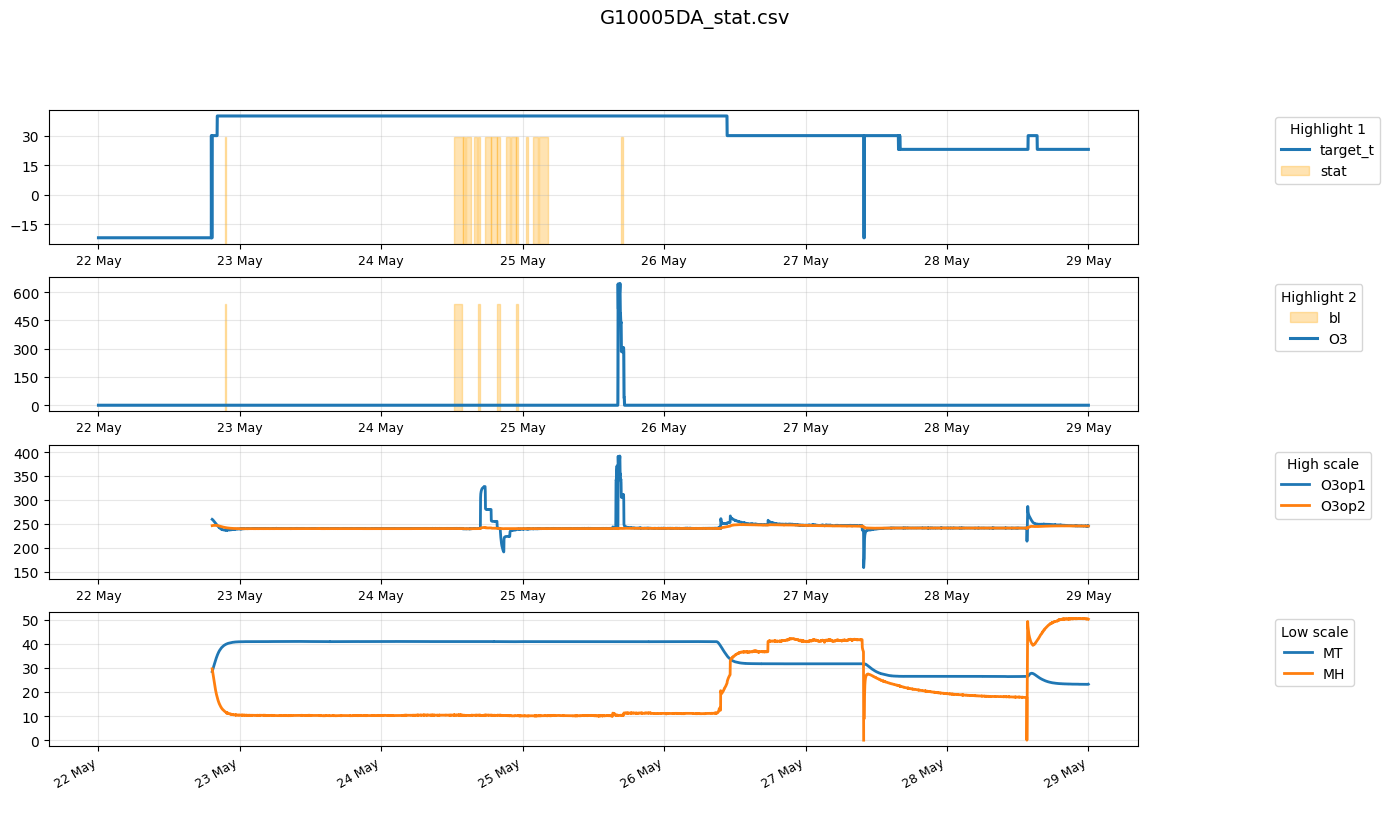

In [59]:
name, ext = os.path.splitext(stat_filename)
filename = f"{name}_stat{ext}"
path ="data_example/lab_data"
df = read_data(path, filename)
if 'ts' in df.columns:  df = df.drop(columns=['ts']) 
# df = df.head(100000)
# print(df.describe())
cols_to_plot = [
                'O3op1',
                'O3op2', 
                # 'O3',
                #'NO2op1','NO2op2',
                'MT',
                  'MH'
                 ]
highlight_cols_1 = [
                    # 'O3op1_bl_auto',
                  'target_t','stat'
                  #'NO2'
                  ]
highlight_cols_2 = [
                    # 'O3op1_bl_auto',
                  'bl',
                  'O3'
                  ]
# cols_to_plot=None
# highlight_cols=None
end_date = "2025-05-29"
plot_data(df, filename, 
          cols_to_plot = cols_to_plot, 
          highlight_cols = [highlight_cols_1, highlight_cols_2],
          # start_date = start_date,
          end_date = end_date,
          )

In [8]:
df['date']

0       2025-05-22 00:00:00
1       2025-05-22 00:01:00
2       2025-05-22 00:02:00
3       2025-05-22 00:03:00
4       2025-05-22 00:04:00
                ...        
28795   2025-06-10 23:55:00
28796   2025-06-10 23:56:00
28797   2025-06-10 23:57:00
28798   2025-06-10 23:58:00
28799   2025-06-10 23:59:00
Name: date, Length: 28800, dtype: datetime64[ns]